In [54]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
import os
from sklearn import datasets
from sklearn.semi_supervised import label_propagation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

N_examples = 890393 # total

N_samples = 5000

def create_dataset(balanced=False):
    y = np.zeros(N_samples)
    i = 0
    n_neg = 0
    corpus = []

    for line in open('train_filtered.csv'):
        label, text = line.split(',')
        label = int(label)

        if label == -1:
            n_neg += 1
            if balanced and n_neg > N_samples / 2:
                continue

        corpus.append(text)
        y[i] = label        

        i += 1        
        if i == N_samples:
            break
    
    vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=5, max_df=0.5, stop_words='english')
    
    X = vectorizer.fit_transform(corpus)
    """
    We change label -1 to 0 and keep -1 to represent unlabeled instances
    """
    y[y==-1] = 0
    
    return X.toarray(), y

def load_dataset():
    fname = "dataset.pickle"
    if os.path.exists(fname):
        dataset = pickle.load(open(fname, 'rb'))
    else:
        dataset = create_dataset()
        pickle.dump(dataset, open(fname, 'wb'))
    X, y = dataset
    return X, y


In [56]:
#!/usr/bin/env python3
"""
The script helps guide the users to quickly understand how to use
libact by going through a simple active learning task with clear
descriptions.
"""

import copy
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

# libact classes
from libact.base.dataset import Dataset, import_libsvm_sparse
from libact.models import *
from libact.query_strategies import *
from libact.labelers import IdealLabeler


def run(trn_ds, tst_ds, lbr, model, qs, quota, batch_size):
    E_in, E_out = [], []

    batch_i = 0
    for _ in range(quota):
        # Standard usage of libact objects
        ask_id = qs.make_query()
        X, _ = zip(*trn_ds.data)
        lb = lbr.label(X[ask_id])
        trn_ds.update(ask_id, lb)
        batch_i += 1
        if batch_i == batch_size:
            model.train(trn_ds)
            batch_i = 0            
            E_in = np.append(E_in, 1 - model.score(trn_ds))
            E_out = np.append(E_out, 1 - model.score(tst_ds))

    return E_in, E_out


def split_train_test(X, y, test_size, n_labeled):
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
    trn_ds = Dataset(X_train, np.concatenate(
        [y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]))
    tst_ds = Dataset(X_test, y_test)
    fully_labeled_trn_ds = Dataset(X_train, y_train)

    return trn_ds, tst_ds, y_train, fully_labeled_trn_ds


In [57]:
X, y = create_dataset(balanced=True)

In [58]:
X.shape

(5000, 3185)

In [59]:
sum(y==1)

2500

In [60]:
# Specifiy the parameters here:

test_size = 0.33    # the percentage of samples in the dataset that will be
                    # randomly selected and assigned to the test set
n_labeled = 100     # number of samples that are initially labeled
batch_size = 100    # number of new queries to fetch before retraining the classifier

# Load dataset
# X, y = load_dataset_reduced()
# X, y = load_dataset()
X, y = create_dataset(balanced=True)

trn_ds, tst_ds, y_train, fully_labeled_trn_ds = \
    split_train_test(X, y, test_size, n_labeled)
trn_ds2 = copy.deepcopy(trn_ds)
lbr = IdealLabeler(fully_labeled_trn_ds)

quota = len(y_train) - n_labeled    # number of samples to query

# Comparing UncertaintySampling strategy with RandomSampling.
# model is the base learner, e.g. LogisticRegression, SVM ... etc.
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression(class_weight='balanced'))
model1 = LogisticRegression(class_weight='balanced')
E_in_1, E_out_1 = run(trn_ds, tst_ds, lbr, model1, qs, quota, batch_size)

qs2 = RandomSampling(trn_ds2)
model2 = LogisticRegression(class_weight='balanced')
E_in_2, E_out_2 = run(trn_ds2, tst_ds, lbr, model2, qs2, quota, batch_size)


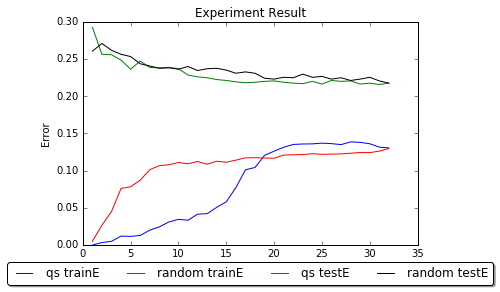

In [61]:
# Plot the learning curve of UncertaintySampling to RandomSampling
# The x-axis is the number of batches, and the y-axis is the corresponding
# error rate.
import math
query_num = np.arange(1, quota + 1)
n_batches = math.floor(quota / batch_size)
batch_num = np.arange(1, n_batches + 1)
plt.plot(batch_num, E_in_1, 'b', label='qs trainE')
plt.plot(batch_num, E_in_2, 'r', label='random trainE')
plt.plot(batch_num, E_out_1, 'g', label='qs testE')
plt.plot(batch_num, E_out_2, 'k', label='random testE')
plt.xlabel('Number of Batches')
plt.ylabel('Error')
plt.title('Experiment Result')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
plt.show()

In [63]:
pred_labels = model2.predict(X)

true_labels = y

cm = confusion_matrix(true_labels, pred_labels)

print(cm)

[[2137  363]
 [ 431 2069]]
